In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm.auto import tqdm
import warnings
from helper import scaffold_split

Enable Pandas progress apply

In [25]:
tqdm.pandas()

Read the data 

In [26]:
df = pd.read_csv("ADME_public_set_3521.csv")

Convert solublity to uM

In [27]:
def compute_mol_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)

df['Molecular Weight'] = df['SMILES'].apply(compute_mol_weight)
df['LOG SOLUBILITY PH 6.8 (uM)'] = ((10**df['LOG SOLUBILITY PH 6.8 (ug/mL)']) * 1000) / df['Molecular Weight']
df['LOG SOLUBILITY PH 6.8 (uM)'] = np.log10(df['LOG SOLUBILITY PH 6.8 (uM)'])

In [28]:
df

,Internal ID,Vendor ID,SMILES,CollectionName,LOG HLM_CLint (mL/min/kg),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG RLM_CLint (mL/min/kg),Molecular Weight,LOG SOLUBILITY PH 6.8 (uM)
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,0.675687,1.493167,0.089905,0.991226,0.518514,1.392169,434.435,0.451980
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,0.675687,1.040780,0.550228,0.099681,0.268344,1.027920,418.444,0.928591
2,Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,0.675687,-0.358806,NaN,2.000000,2.000000,1.027920,210.256,NaN
3,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,0.675687,1.026662,1.657056,-1.158015,-1.403403,1.027920,382.847,2.074031
4,Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,0.996380,1.010597,NaN,1.015611,1.092264,1.629093,450.461,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3516,Mol3517,43258693,O=C(c1ccc2c(c1)CCCC2)N1CCOCC1c1ccn[nH]1,emolecules,NaN,0.606813,NaN,NaN,NaN,NaN,311.385,NaN
3517,Mol3518,27448206,O=C(Nc1nc2ccccc2[nH]1)c1ccc(-n2cccc2)cc1,emolecules,NaN,-0.444495,NaN,NaN,NaN,NaN,302.337,NaN
3518,Mol3519,207150215,NC(=O)c1noc([C@@H](CCCC2CCCCC2)CC(=O)NO)n1,emolecules,0.863799,NaN,NaN,NaN,NaN,NaN,324.381,NaN
3519,Mol3520,25037224,CCCCCCCCc1ccc(CC[C@](N)(CO)COP(=O)(O)O)cc1,emolecules,0.881385,NaN,NaN,NaN,NaN,NaN,387.457,NaN


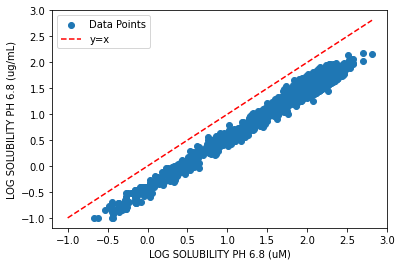

In [29]:
plt.scatter(df[ "LOG SOLUBILITY PH 6.8 (uM)"], df["LOG SOLUBILITY PH 6.8 (ug/mL)"], label='Data Points')
min_val = min(df[ "LOG SOLUBILITY PH 6.8 (uM)"].min(), df["LOG SOLUBILITY PH 6.8 (ug/mL)"].min())
max_val = max(df[ "LOG SOLUBILITY PH 6.8 (uM)"].max(), df["LOG SOLUBILITY PH 6.8 (ug/mL)"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x')
plt.xlabel( "LOG SOLUBILITY PH 6.8 (uM)")
plt.ylabel("LOG SOLUBILITY PH 6.8 (ug/mL)")
plt.legend()
plt.show()

array([[<AxesSubplot:title={'center':'LOG SOLUBILITY PH 6.8 (uM)'}>,
        <AxesSubplot:title={'center':'LOG SOLUBILITY PH 6.8 (ug/mL)'}>]],
      dtype=object)

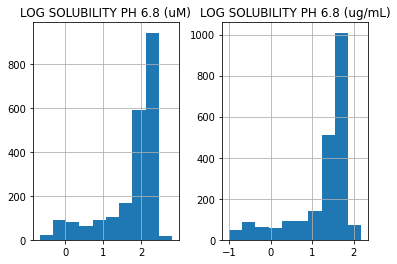

In [30]:
df[["LOG SOLUBILITY PH 6.8 (uM)", "LOG SOLUBILITY PH 6.8 (ug/mL)"]].hist()

Add an RDKit molecule to the dataframe.  

In [31]:
df = df.drop(['LOG SOLUBILITY PH 6.8 (ug/mL)', 'Molecular Weight'],axis=1)
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/3521 [00:00<?, ?it/s]

Delete rows where the SMILES couldn't be parsed

In [32]:
df_ok = df.dropna(subset=['mol']).copy()

Make sure we don't have duplicate molecules

In [33]:
df_ok['cansmi'] = df_ok.mol.apply(Chem.MolToSmiles)

In [34]:
df_ok.cansmi.value_counts()

CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H]3C[C@@H]3F)cnc12    1
Cc1nccc(NC(=O)CCc2ccncc2)c1Cl                                      1
CCc1nnc(N2CC(N(C)C)C2)c(C#N)c1CC                                   1
CCc1nnc(Nc2cc(C)nc(C3CN(C(=O)C(C)C)CCO3)c2)s1                      1
O=C(Nc1ccncc1)[C@H]1CCCN(S(=O)(=O)c2ccc(Cl)cc2)C1                  1
                                                                  ..
O=C(c1ccccn1)N1CCCC(c2cccc(-c3cccc(Cl)c3)n2)C1                     1
CN1CCN(c2ccc(NC(=O)c3ccc(S(=O)(=O)N4CCCc5ccccc54)cc3)cc2)CC1       1
Cc1cnn(Cc2nc(Cn3cccn3)no2)c1                                       1
COc1ccccc1CC(=O)Nc1ncc(C)s1                                        1
Cc1cccc(/C=N/Nc2cc(N3CCOCC3)n3nc(-c4ccncc4)cc3n2)c1                1
Name: cansmi, Length: 3521, dtype: int64

Drop the molecule column

In [35]:
df_ok = df_ok.drop(["mol","cansmi"],axis=1)

Double check the sizes of the dataframes

In [36]:
len(df),len(df_ok),len(df)-len(df_ok)

(3521, 3521, 0)

Create two dataframes, one with the molecules that have Sol data and one with the molecules that don't. For single task, we'll only use the molecules with Sol data.  For multitask, we'll use all the data. 

In [37]:
rename_ls = ['Name',
 'Vendor ID',
 'SMILES',
 'CollectionName',
 'HLM_CLint',
 'ER',
 'HPPB',
 'RPPB',
 'RLM_CLint',
 'Sol']
rename_dic = dict(zip(df_ok.columns.tolist(), rename_ls))
rename_dic

{'Internal ID': 'Name',
 'Vendor ID': 'Vendor ID',
 'SMILES': 'SMILES',
 'CollectionName': 'CollectionName',
 'LOG HLM_CLint (mL/min/kg)': 'HLM_CLint',
 'LOG MDR1-MDCK ER (B-A/A-B)': 'ER',
 'LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)': 'HPPB',
 'LOG PLASMA PROTEIN BINDING (RAT) (% unbound)': 'RPPB',
 'LOG RLM_CLint (mL/min/kg)': 'RLM_CLint',
 'LOG SOLUBILITY PH 6.8 (uM)': 'Sol'}

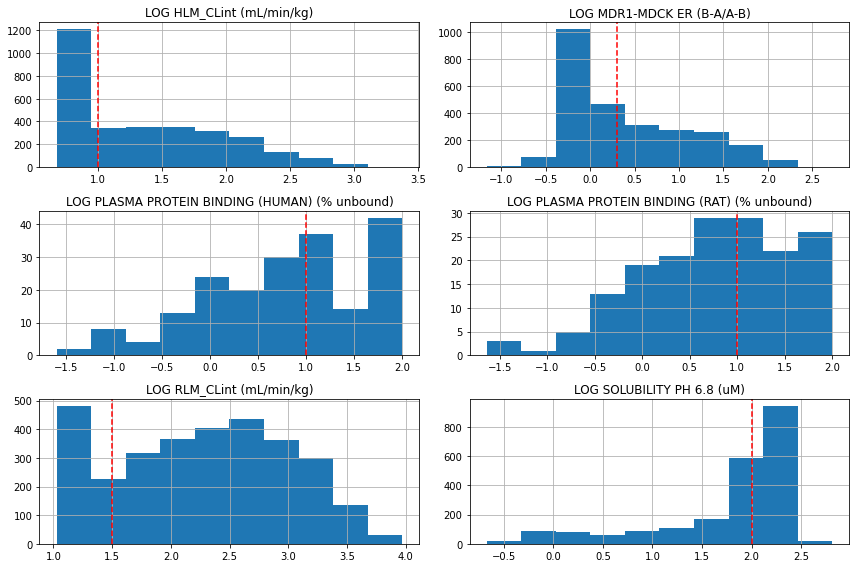

In [38]:
thresholds = [1, .3, 1, 1, 1.5, 2]
axes = df_ok.hist(figsize = (12, 8)).flatten()
for i, ax in enumerate(axes):
    ax.axvline(thresholds[i], color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [39]:
df_ok = df_ok.rename(columns=rename_dic)

In [40]:
def make_class_column(class_name, col_name, thresh, direction):
    if direction == "greater":
        df_ok[class_name] = (df_ok[col_name].copy() > thresh).astype(int)
    elif direction == "lesser":
        df_ok[class_name] = (df_ok[col_name].copy() < thresh).astype(int)
    else:
        print("error")
        return
    df_ok.loc[df_ok[col_name].isnull(), class_name]=np.nan

In [41]:
make_class_column("HLM_CLint_class", 'HLM_CLint', 1, "lesser")
make_class_column("ER_class", 'ER', .3, "lesser") # less than 2
make_class_column("HPPB_class", 'HPPB', 1, "greater")
make_class_column("RPPB_class", 'RPPB', 1, "greater")
make_class_column("RLM_CLint_class", 'RLM_CLint', 1.5, "lesser")
make_class_column("Sol_class", 'Sol', 2, "greater")


In [42]:
# Show counts of positives and negatives for each class
for col in df_ok.columns:
    if "_class" in col:
        print(df_ok[col].value_counts())

0.0    1822
1.0    1265
Name: HLM_CLint_class, dtype: int64
1.0    1484
0.0    1158
Name: ER_class, dtype: int64
0.0    114
1.0     80
Name: HPPB_class, dtype: int64
0.0    98
1.0    70
Name: RPPB_class, dtype: int64
0.0    2434
1.0     620
Name: RLM_CLint_class, dtype: int64
1.0    1278
0.0     895
Name: Sol_class, dtype: int64


In [43]:
df_ok.describe()

,HLM_CLint,ER,HPPB,RPPB,RLM_CLint,Sol,HLM_CLint_class,ER_class,HPPB_class,RPPB_class,RLM_CLint_class,Sol_class
count,3087.000000,2642.000000,194.000000,168.000000,3054.000000,2173.000000,3087.000000,2642.000000,194.000000,168.000000,3054.000000,2173.000000
mean,1.320019,0.397829,0.765722,0.764177,2.256207,1.763007,0.409783,0.561696,0.412371,0.416667,0.203012,0.588127
std,0.623952,0.688465,0.847902,0.798988,0.750422,0.709761,0.491873,0.496273,0.493535,0.494481,0.402308,0.492286
min,0.675687,-1.162425,-1.593460,-1.638272,1.027920,-0.669644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.675687,-0.162356,0.168067,0.226564,1.688291,1.653526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.205313,0.153291,0.867555,0.776427,2.311068,2.079245,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.803115,0.905013,1.501953,1.375962,2.835274,2.201339,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3.372714,2.725057,2.000000,2.000000,3.969622,2.811696,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
df_ok = df_ok.drop([ 'HLM_CLint',
 'ER',
 'HPPB',
 'RPPB',
 'RLM_CLint',
 'Sol'],axis=1)
df_ok.columns = df_ok.columns.str.replace('_class$', '', regex=True)
df_ok

,Name,Vendor ID,SMILES,CollectionName,HLM_CLint,ER,HPPB,RPPB,RLM_CLint,Sol
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,1.0,0.0,0.0,0.0,1.0,0.0
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,1.0,0.0,0.0,0.0,1.0,0.0
2,Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,1.0,1.0,1.0,1.0,1.0,NaN
3,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,1.0,0.0,0.0,0.0,1.0,1.0
4,Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,1.0,0.0,1.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
3516,Mol3517,43258693,O=C(c1ccc2c(c1)CCCC2)N1CCOCC1c1ccn[nH]1,emolecules,NaN,0.0,NaN,NaN,NaN,NaN
3517,Mol3518,27448206,O=C(Nc1nc2ccccc2[nH]1)c1ccc(-n2cccc2)cc1,emolecules,NaN,1.0,NaN,NaN,NaN,NaN
3518,Mol3519,207150215,NC(=O)c1noc([C@@H](CCCC2CCCCC2)CC(=O)NO)n1,emolecules,1.0,NaN,NaN,NaN,NaN,NaN
3519,Mol3520,25037224,CCCCCCCCc1ccc(CC[C@](N)(CO)COP(=O)(O)O)cc1,emolecules,1.0,NaN,NaN,NaN,NaN,NaN


In [45]:
df_sol = df_ok.dropna(subset=["Sol"]).copy()
df_rest = df_ok[df_ok.Sol.isna()].copy()

In [46]:
df_rest

,Name,Vendor ID,SMILES,CollectionName,HLM_CLint,ER,HPPB,RPPB,RLM_CLint,Sol
2,Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,1.0,1.0,1.0,1.0,1.0,NaN
4,Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,1.0,0.0,1.0,1.0,0.0,NaN
6,Mol7,299985775,CC(C)NCC(O)COc1cccc2ccccc12,emolecules,0.0,1.0,NaN,1.0,0.0,NaN
7,Mol8,538570,COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2...,emolecules,0.0,0.0,0.0,0.0,0.0,NaN
9,Mol10,44811418,CC(C)NC(=O)COc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3...,emolecules,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
3516,Mol3517,43258693,O=C(c1ccc2c(c1)CCCC2)N1CCOCC1c1ccn[nH]1,emolecules,NaN,0.0,NaN,NaN,NaN,NaN
3517,Mol3518,27448206,O=C(Nc1nc2ccccc2[nH]1)c1ccc(-n2cccc2)cc1,emolecules,NaN,1.0,NaN,NaN,NaN,NaN
3518,Mol3519,207150215,NC(=O)c1noc([C@@H](CCCC2CCCCC2)CC(=O)NO)n1,emolecules,1.0,NaN,NaN,NaN,NaN,NaN
3519,Mol3520,25037224,CCCCCCCCc1ccc(CC[C@](N)(CO)COP(=O)(O)O)cc1,emolecules,1.0,NaN,NaN,NaN,NaN,NaN


There are some sizeable series, so go ahead with scaffold split

In [47]:
from helper import scaffold_to_smiles

scaffold_to_indices = scaffold_to_smiles(df_ok.SMILES, use_indices=True)
counts = {key: len(value) for key, value in scaffold_to_indices.items()}
df = pd.DataFrame(counts.items(), columns=['Item', 'Count'])

df_sorted = df.sort_values(by='Count', ascending=False).reset_index(drop=True)
df_sorted.head(20)

,Item,Count
0,c1ccccc1,50
1,c1ccc2ncccc2c1,16
2,c1ccncc1,16
3,c1ccc(-n2cccn2)cc1,12
4,O=C(CN1CCCN(c2ccccn2)CC1)Nc1ccccc1,10
5,c1ccc(-c2cscn2)cc1,10
6,c1cn[nH]c1,10
7,c1ccc2[nH]cnc2c1,8
8,c1ccc2[nH]ccc2c1,8
9,O=S(=O)(Nc1ccccc1)c1ccccc1,8


Write the splits to disk. Supress warnings because we're writing floats and NAs in a column. 

In [48]:
# df_sol['Sol_bins'] = pd.cut(df_sol['Sol'], bins=10, labels=False)

warnings.simplefilter(action = "ignore", category = RuntimeWarning)
dataset = {}

if not os.path.exists("data"):
        os.mkdir("data")
base_name = "data/Sol"
for i in tqdm(range(0,10)):
    dir_name = f"{base_name}{i:03d}"
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # random split
    rnd_train, rnd_val_test = train_test_split(df_sol,test_size=0.2,stratify=df_sol.Sol,random_state=i)
    rnd_val, rnd_test = train_test_split(rnd_val_test, test_size=0.5,stratify=rnd_val_test.Sol,random_state=i)
    dataset["random"] = [rnd_train, rnd_val, rnd_test]
    # scaffold split
    scaf_train, scaf_val_test = scaffold_split(df_sol.SMILES,sizes=(0.8,0.2),seed=i)
    df_scaf_train = df_sol.iloc[scaf_train]
    df_scaf_val_test = df_sol.iloc[scaf_val_test]
    scaf_val, scaf_test = scaffold_split(df_scaf_val_test.SMILES,sizes=(0.5,0.5),seed=i)
    df_scaf_val = df_scaf_val_test.iloc[scaf_val]
    df_scaf_test = df_scaf_val_test.iloc[scaf_test]    
    dataset["scaffold"] = [df_scaf_train, df_scaf_val, df_scaf_test]
    
    for prefix in ["random", "scaffold"]:
        train, val, test = dataset[prefix]
    
        st_cols = ["SMILES","Name","Sol"]
        train[st_cols].to_csv(f"{dir_name}/{prefix}_train_{i:03d}.csv",index=False)
        val[st_cols].to_csv(f"{dir_name}/{prefix}_val_{i:03d}.csv",index=False)
        test[st_cols].to_csv(f"{dir_name}/{prefix}_test_{i:03d}.csv",index=False)
    
        mt_cols = ["SMILES","Name","Sol","HLM_CLint","RLM_CLint","ER","HPPB","RPPB"]
        rest_train, rest_val = train_test_split(df_rest,test_size=0.2,random_state=i)
        train = pd.concat([train, rest_train]).sample(frac=1.0)
        train[mt_cols].to_csv(f"{dir_name}/{prefix}_mt_train_{i:03d}.csv",index=False)
        val = pd.concat([val, rest_val]).sample(frac=1.0)
        val[mt_cols].to_csv(f"{dir_name}/{prefix}_mt_val_{i:03d}.csv",index=False)
        test[mt_cols].to_csv(f"{dir_name}/{prefix}_mt_test_{i:03d}.csv",index=False)

  0%|          | 0/10 [00:00<?, ?it/s]